# 2.2 Coalition or Sum: numerical comparisons
## 2.2.2 CENSUS INCOME DATA (Reproduction of figure 3)

In [1]:
import warnings
warnings.filterwarnings('ignore')

from acv_explainers import ACVTree
import shap

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import random 
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
random.seed(2021)
np.random.seed(2021)

## Load data

In [4]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
num_features = X.shape[1]

X =  pd.concat([X, 
                    pd.get_dummies(X['Workclass'], prefix='work'), pd.get_dummies(X['Marital Status'], prefix='status'), 
                    pd.get_dummies(X['Race'], prefix='race'), pd.get_dummies(X['Education-Num'], prefix='education')], axis=1)

X.drop(['Workclass', 'Education-Num', 'Marital Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Capital Loss',
       'Hours per week', 'Country', 'Age', 'Capital Gain'], axis=1, inplace=True)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=7)

In [5]:
X_train.head()

,work_0,work_1,work_2,work_3,work_4,work_5,work_6,work_7,work_8,status_0,...,education_7.0,education_8.0,education_9.0,education_10.0,education_11.0,education_12.0,education_13.0,education_14.0,education_15.0,education_16.0
936,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13780,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
20164,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
29844,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2235,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [6]:
# size = 2

In [7]:
# index of the dummies variables

index_dummies_relation = [i for i in range(X_train.shape[1]) if 'relation' in X_train.columns[i]]
index_dummies_work = [i for i in range(X_train.shape[1]) if 'work' in X_train.columns[i]]
index_dummies_status = [i for i in range(X_train.shape[1]) if 'status' in X_train.columns[i]]
index_dummies_race = [i for i in range(X_train.shape[1]) if 'race' in X_train.columns[i]]
index_dummies_education = [i for i in range(X_train.shape[1]) if 'education' in X_train.columns[i]]

C = [index_dummies_work, index_dummies_status, index_dummies_race, index_dummies_education]

In [8]:
# Model training 

tree = DecisionTreeClassifier(min_samples_leaf=25, max_depth=15, max_features=10, random_state=700)
tree.fit(X_train, y_train)

forest = RandomForestClassifier(n_estimators=2, max_features=10, max_depth=5, min_samples_leaf=40, random_state=2021)
forest.fit(X_train, y_train)

error_train = roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])
error_test = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
print('[* FOREST *]')
print('train err = {} --- test err = {}'.format(error_train, error_test))

error_train = roc_auc_score(y_train, tree.predict_proba(X_train)[:, 1])
error_test = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
print('[* TREE *]')
print('train err = {} --- test err = {}'.format(error_train, error_test))

[* FOREST *]
train err = 0.8259221093613662 --- test err = 0.8308672584719337
[* TREE *]
train err = 0.8622027570247591 --- test err = 0.8609861580910045


## Build ACVTree for explanations

In [9]:
acvtree = ACVTree(forest, X_train.values)

## Comparisons of Global SV with Coalition or SUM

In [10]:
nb = 5000
shap_coal = acvtree.shap_values(X_train.values[:nb], C=C)[:, :, 1]
mean_shap_coal = np.mean(np.abs(shap_coal), axis=0)

100%|██████████| 13/13 [00:00<00:00, 78.14it/s]


In [11]:
# Computation of SV with SUM
nb = 5000
shap_sum = acvtree.shap_values(X_train.values[:nb], C=[[]])[:, :, 1]

for c in C:
    cat_va = np.sum(shap_sum[:, c], axis=1)
    for c_i in c:
        shap_sum[:, c_i] = cat_va

mean_shap_sum = np.mean(np.abs(shap_sum), axis=0)

100%|██████████| 13/13 [00:00<00:00, 35.31it/s]


In [12]:
# Proportion of order inversion 

err_sort_ind = []
err_sign_ind = []
index_inversion = []
for i in range(nb):
    coal_sort = np.argsort(np.abs(shap_coal[i]))
    sum_sort = np.argsort(np.abs(shap_sum[i]))
    
    err_sort = (np.sum(coal_sort != sum_sort) >= 2)
    if err_sort != 0:
        index_inversion.append(i)
    err_sign = np.sum(np.sign(shap_coal[i]) * np.sign(shap_sum[i]) != 1)
    
    err_sort_ind.append(err_sort)
    err_sign_ind.append(err_sign)

In [13]:
np.sum(err_sort_ind)

298

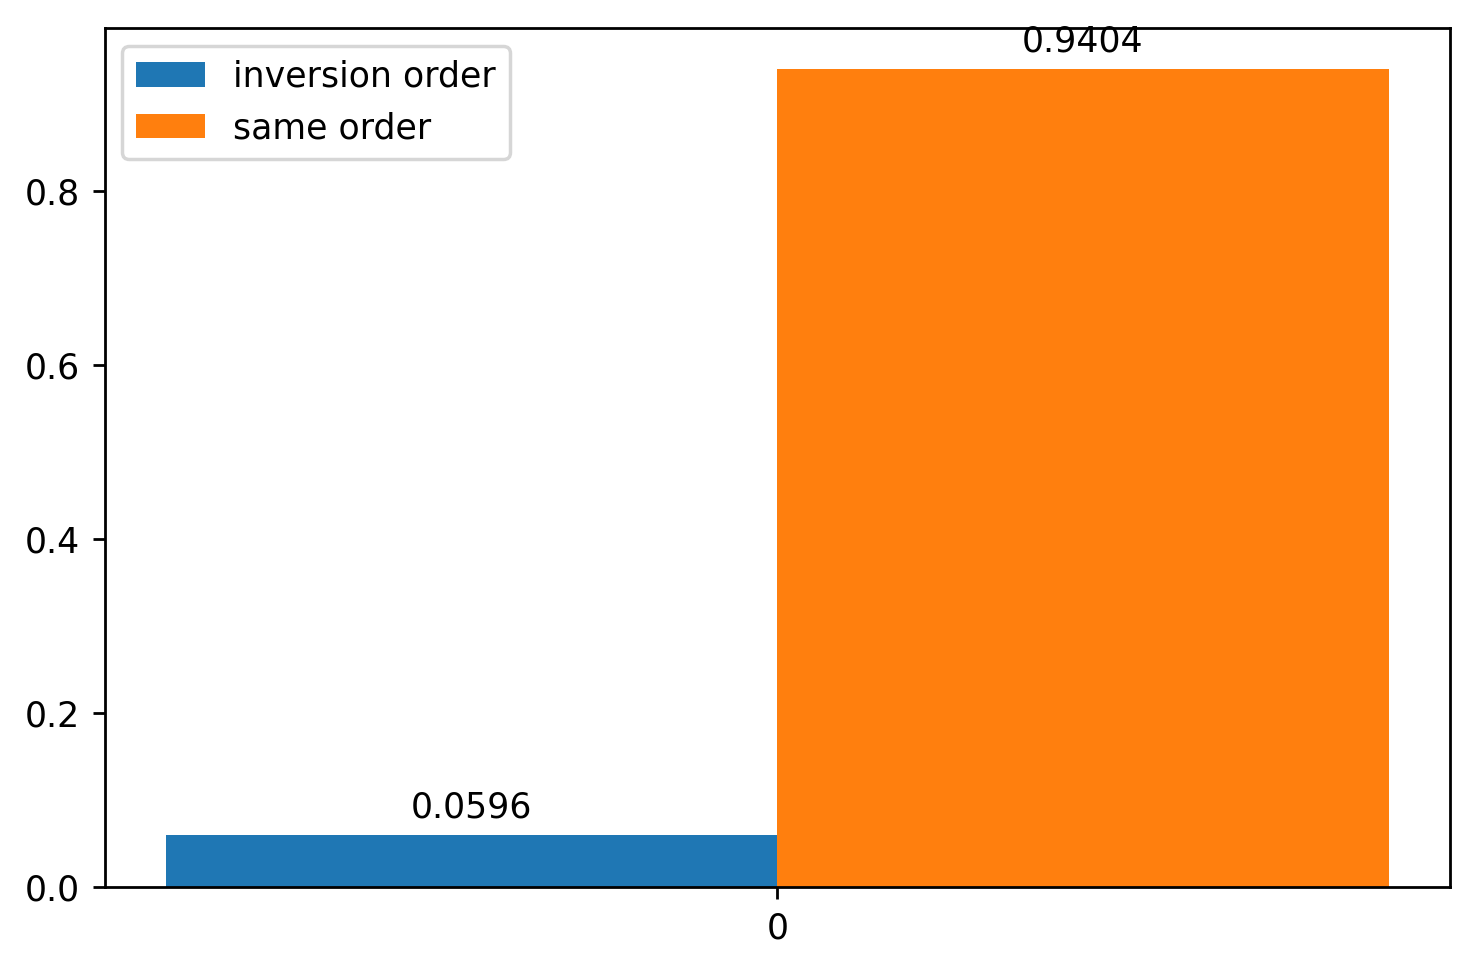

In [14]:
labels = ['inversion order', 'same order']
x = np.arange(1)  # the label locations
width = 2  # the width of the bars

fig, ax = plt.subplots(dpi=250)
rects1 = ax.bar(x - width/2, np.sum(err_sort_ind)/nb, width, label = labels[0])
rects2 = ax.bar(x + width/2, 1-(np.sum(err_sort_ind)/nb), width, label = labels[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('')
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
# ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='black')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [15]:
# m_shap_coal = np.concatenate([mean_shap_coal[:size], [mean_shap_coal[c][0] for c in C]], axis=0)
# m_shap_sum = np.concatenate([mean_shap_sum[:size], [mean_shap_sum[c][0] for c in C]], axis=0)

m_shap_coal = [mean_shap_coal[c][0] for c in C]
m_shap_sum = [mean_shap_sum[c][0] for c in C]

In [16]:
def plot_feature_importance(importance, names, title, xlabel='SHAP values'):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    seaborn_colors = sns.color_palette("tab10")
    colors = {names[i]: seaborn_colors[i] for i in range(len(names))}

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.set(font_scale=1.5) 
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette=colors)
    #Add chart labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('FEATURE NAMES')


In [17]:
columns_names = ['Workclass', 'Marital Status', 'Race', 'Education'] 

# plot_feature_importance(m_shap_coal, columns_names, 'mean absolute SHAP coal ')
# plot_feature_importance(m_shap_sum, columns_names, 'mean absolute SHAP SUM ')

2866


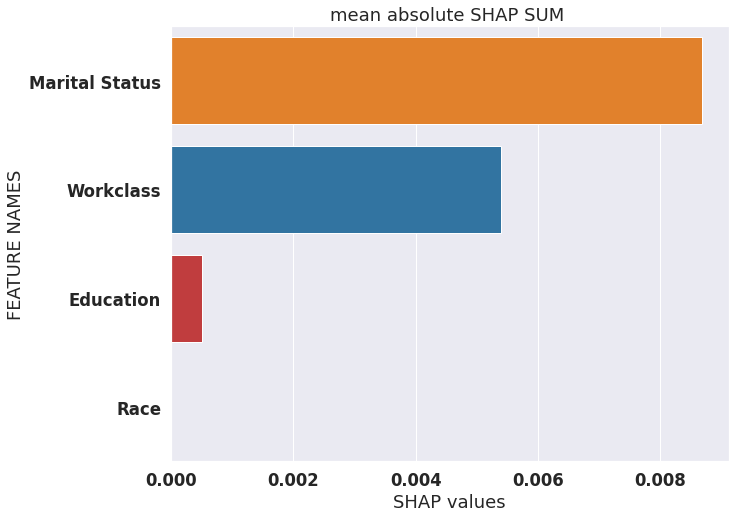

In [18]:
plt.rcParams["font.weight"] = "bold"

idx = index_inversion[np.random.randint(0, len(index_inversion))]
idx = 2866
m_shap_coal = [shap_coal[idx, c][0] for c in C]
m_forest_sum = [shap_sum[idx, c][0] for c in C]

plot_feature_importance(np.abs(m_forest_sum), columns_names, 'mean absolute SHAP SUM ')
print(idx)

### Figure 4: The left figure, SV with sum of the dummies variables

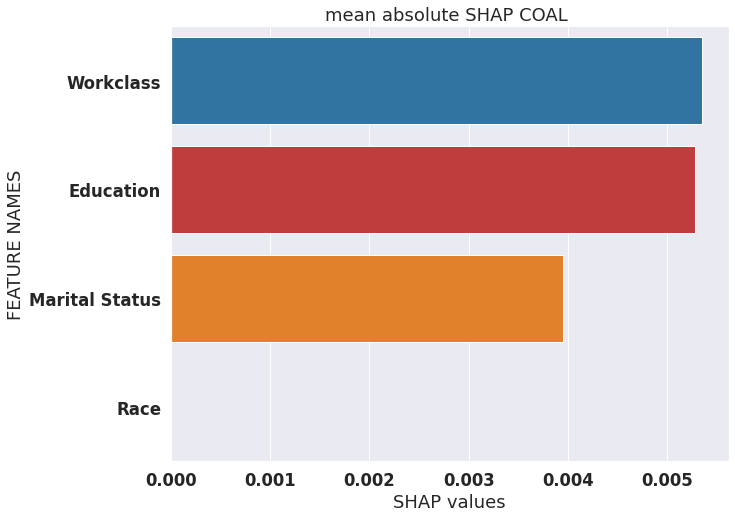

In [19]:
plot_feature_importance(np.abs(m_shap_coal), columns_names, 'mean absolute SHAP COAL ')

### Figure 4: The right figure, SV with coalition of the dummies variables